In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from simpleparamaterisation import TPCevt as TPC
from scipy.stats import multivariate_normal

det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

Welcome to JupyROOT 6.28/00


In [7]:
print(det.PSFstd)
det.PSFstd = 0.01
print(det.PSFstd)

1
0.01


In [2]:
pitch_x = 0.1
pitch_y = 0.1
rv = multivariate_normal([0,0], np.diag([det.PSFstd, det.PSFstd]))
thresh = 1e-20

def getDistribution(grid_size):
    x, y = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y
            ]
    pos = np.stack((x, y), axis =-1)
    gain = np.random.exponential(scale=det.gain_mean)
    readout = rv.pdf(pos)*pitch_x*pitch_y*gain
    return x, y, readout

def createLocalCoord(size, thresh):
    x, y, val = getDistribution(size)
    mask = val >= thresh
    x_filtered = x[mask].flatten()
    y_filtered = y[mask].flatten()
    val_filtered = val[mask]
    return np.stack((x_filtered, y_filtered, val_filtered))

def transformCoord(coord, dx, dy):
    coord[0] += dx
    coord[1] += dy
    return coord

def filterCoord(x, y, val, minvals, maxvals):
    filtered_x = []
    filtered_y = []
    filtered_val = []
    
    for x_val, y_val, v in zip(x, y, val):
        if minvals[0] <= x_val <= maxvals[0] and minvals[1] <= y_val <= maxvals[1]:
            filtered_x.append(x_val)
            filtered_y.append(y_val)
            filtered_val.append(v)
            
    return [filtered_x, filtered_y, filtered_val]

def ReadoutGain(DriftedEvt):

    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max()])

    def combineData(x, y, val):
        for i in range(len(x)):
            key = (x[i], y[i])
            if key in CombinedEvt:
                CombinedEvt[key] += val[i]
            else:
                CombinedEvt[key] = val[i]

    CombinedEvt = {}

    for i in range(len(DriftedEvt)):
        # Create the Distribution for each of DriftedEvt items
        local_coord = createLocalCoord(500, thresh)
        
        # Transform the coordinate to global based on the centre value of each DriftedEvt items
        global_coord = transformCoord(local_coord, DriftedEvt[i][0], DriftedEvt[i][1] )
        # print('global_coord: ', global_coord[2])
        # Combine the data
        combineData(global_coord[0], global_coord[1], global_coord[2])
        
    x_comb, y_comb = zip(*CombinedEvt.keys())
    val_comb = list(CombinedEvt.values())

    filtered_coord = filterCoord(x_comb, y_comb, val_comb, minvals, maxvals)
    # print('val combined', val_comb)
    # print(filtered_coord)
    # print('filtered_coord', filtered_coord[2])
    
    return filtered_coord



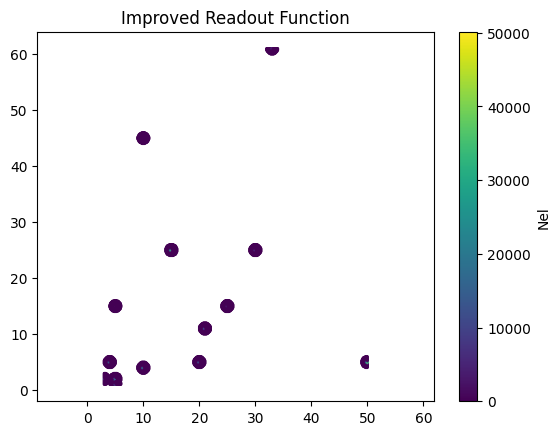

In [3]:
DriftedEvt = np.array([[5,1],[50,5],[5,15],[5,2], [20, 5], [30, 25], [15, 25], [25, 15], [10, 45], [33, 61], [21,11], [3,2], [4,5], [10,4]])

ReadoutEvt = ReadoutGain(DriftedEvt)

plt.figure()
plt.title('Improved Readout Function')
plt.axis('equal')
plt.scatter(ReadoutEvt[0], ReadoutEvt[1], c = ReadoutEvt[2], s=1)
plt.colorbar().set_label('Nel')

In [5]:
print(60164/80)

752.05


In [6]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('DriftedEvt', 352),
 ('ReadoutGain', 152),
 ('createLocalCoord', 152),
 ('filterCoord', 152),
 ('getDistribution', 152),
 ('open', 152),
 ('transformCoord', 152),
 ('ReadoutEvt', 80),
 ('TPC', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('det', 56),
 ('multivariate_normal', 56),
 ('rv', 56),
 ('pitch_x', 24),
 ('pitch_y', 24),
 ('thresh', 24)]

In [7]:
print(4076/80)

50.95


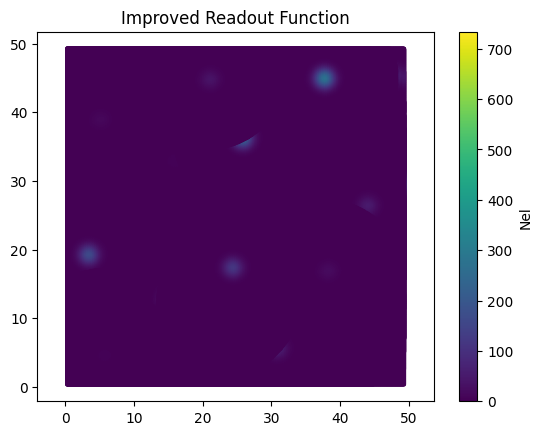

In [8]:
import numpy as np

N = 100
min_x, max_x = 0, 50
min_y, max_y = 0, 50
# Set a seed for reproducibility
np.random.seed(42)

# Generate random x and y values within the given range
x_values = np.random.rand(N) * (max_x - min_x) + min_x
y_values = np.random.rand(N) * (max_y - min_y) + min_y

# Create the numpy array with the x and y values
DriftedEvt2 = np.array([x_values, y_values]).T


ReadoutEvt2 = ReadoutGain(DriftedEvt2)

plt.figure()
plt.title('Improved Readout Function')
plt.axis('equal')
plt.scatter(ReadoutEvt2[0], ReadoutEvt2[1], c = ReadoutEvt2[2], s=5)
plt.colorbar().set_label('Nel')

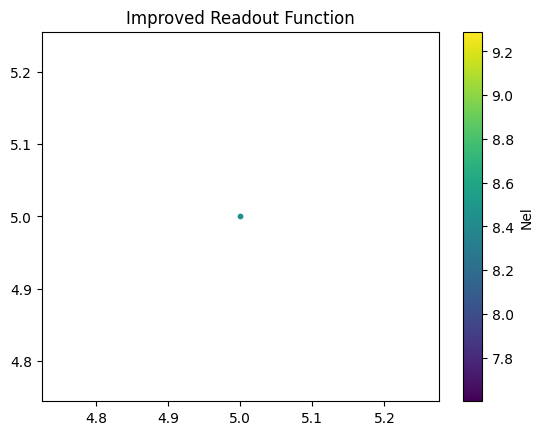

In [9]:
DriftedEvt = [[5,5]]
ReadoutEvt = ReadoutGain(DriftedEvt)

plt.figure()
plt.title('Improved Readout Function')
plt.axis('equal')
plt.scatter(ReadoutEvt[0], ReadoutEvt[1], c = ReadoutEvt[2], s=10)
plt.colorbar().set_label('Nel')

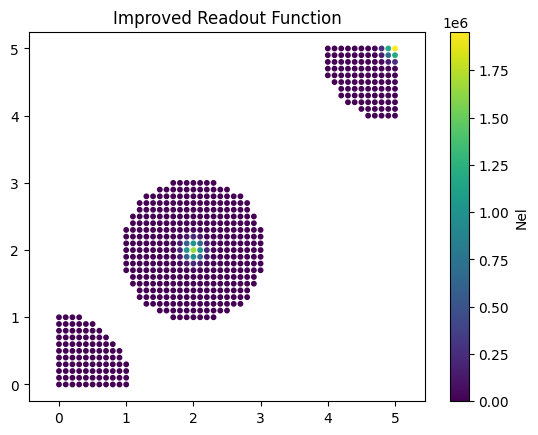

In [4]:
DriftedEvt = np.array([[5, 5], [0, 0]] + [[2, 2] for i in range(100)] + [[5,5] for i in range(100)])
ReadoutEvt = ReadoutGain(DriftedEvt)

plt.figure()
plt.title('Improved Readout Function')
plt.axis('equal')
plt.scatter(ReadoutEvt[0], ReadoutEvt[1], c = ReadoutEvt[2], s=10)
plt.colorbar().set_label('Nel')

Parameter: 
1. Size of local Coordinate
2. Standard Deviation of the Point Spread Function
3. Applied Thereshold